In [1]:
import os.path as op
import random

import matplotlib.pyplot as plt
import pandas as pd
import yaml

from agents import GreedyAgent
from agents.matchmanager import MatchManager
from agents.ml.classifier import ClassifierAgent
from agents.ml.regression import RegressionAgent
from core.const import RED, BLUE
from core.game.state import vectorStateInfo, vectorState, vectorActionInfo, vectorAction
from scenarios import scenarioJunction

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,4)

In [2]:
with open(op.join('.', 'logger.config.yaml'), 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)
# logging.config.dictConfig(config)

Functions definition:

In [3]:
def player(team:str, data:tuple, seed:int):
    if data[0] == 'gre':
        print(f'{team:5}-> GreedyAgent')
        return GreedyAgent(team, seed=seed)
    if data[0] == 'cls':
        print(f'{team:5}-> ClassifierAgent')
        return ClassifierAgent(team, data[1], seed=seed)
    if data[0] == 'reg':
        print(f'{team:5}-> RegressionAgent')
        return RegressionAgent(team, data[1], seed=seed)
    
    return None

In [4]:
def gameJunction(seed:int, red:tuple, blue:tuple) -> MatchManager:
    board, state = scenarioJunction()
    
    print('seed:   ', seed)
    
    playerRed = player(RED, red, seed)
    playerBlue = player(BLUE, blue, seed)

    mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
    while not mm.end:
        mm.nextStep()
    
    print('winner: ', mm.winner)

    return mm

In [5]:
def prepareDataFrames(mm:MatchManager):
    df_states = pd.DataFrame(
        columns=vectorStateInfo(),
        data=[vectorState(x) for x in mm.states_history]
    )

    df_actions = pd.DataFrame(
        columns=vectorActionInfo(),
        data=[vectorAction(x) for x in mm.actions_history]
    )
    df_red = mm.red.createDataFrame()
    df_blue = mm.blue.createDataFrame()
    
    df_red = df_red.set_index('count')
    df_blue = df_blue.set_index('count')

    return df_red, df_blue, df_states, df_actions

Plot functions:

In [6]:
def plotEntropy(df, color:str):
    plt.figure()
    df.score.plot(color=color, marker='.')
    df.entropy.plot(color='purple')

    for i, row in df[['score','action']].reset_index().iterrows():
        dy, ha, va = (-0, 'center', 'top') if 'Respond' in row.action else (10, 'center', 'bottom')
        plt.annotate(row.action, (row['count'], row.score), ha=ha, va=va, rotation=90, textcoords="offset points", xytext=(0,dy))
        
    for x in df[['turn']].reset_index().groupby('turn').max().values.tolist():
        plt.axvline(x=x[0]+0.5, color='orange')

In [7]:
def plotContrast(df):
    df[df['team']=='red']['entropy'].plot(color='red'), df[df['team']=='blue']['entropy'].plot(color='blue')

Main analysis function:

In [8]:
def playAndAnalyze(seed:int, red_data, blue_data):  
    mm = gameJunction(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    plotEntropy(df_red, 'red')
    plotEntropy(df_blue, 'blue')
    
    return df_red, df_blue

In [9]:
red_models = [
    ('gre', ''),
    ('cls', 'models/Junction_RandomForestClassifier_red_20210217.joblib'),
    ('cls', 'models/Junction_RandomForestClassifier_20210217.joblib'),
    ('reg', 'models/Junction_RandomForestRegressor_red_20210217.joblib'),
    ('reg', 'models/Junction_RandomForestRegressor_20210217.joblib')
]
blue_models = [
    ('gre', ''),
    ('cls', 'models/Junction_RandomForestClassifier_blue_20210217.joblib'),
    ('cls', 'models/Junction_RandomForestClassifier_20210217.joblib'),
    ('reg', 'models/Junction_RandomForestRegressor_blue_20210217.joblib'),
    ('reg', 'models/Junction_RandomForestRegressor_20210217.joblib')
]

In [10]:
seed = 51

# Regressions

seed:    51
red  -> RegressionAgent
blue -> RegressionAgent
winner:  blue


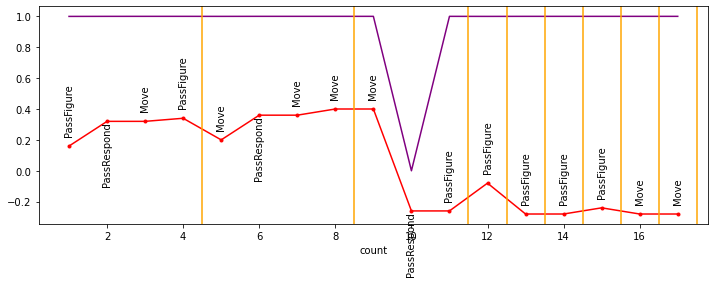

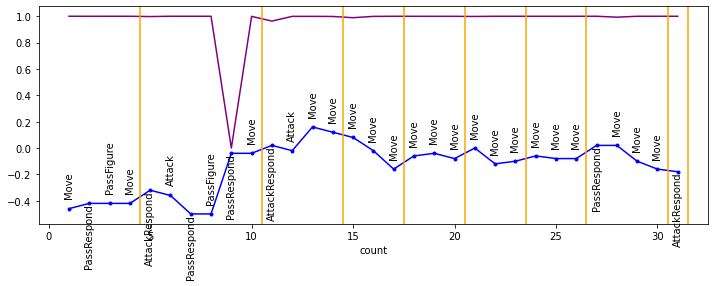

In [11]:
playAndAnalyze(seed, red_models[3], blue_models[3]);

# Classifiers

seed:    51
red  -> ClassifierAgent
blue -> ClassifierAgent
winner:  blue


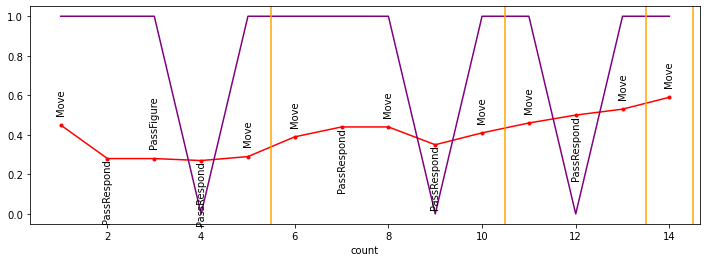

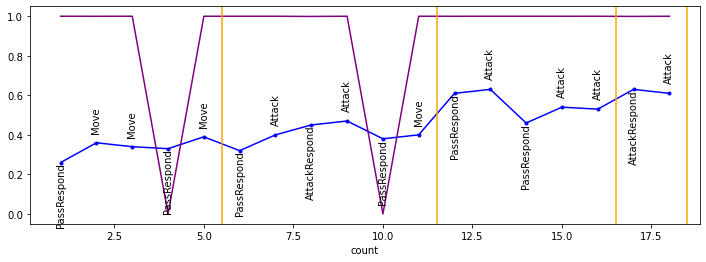

In [12]:
playAndAnalyze(seed, red_models[1], blue_models[1]);

# Greedy

seed:    51
red  -> GreedyAgent
blue -> GreedyAgent
winner:  blue


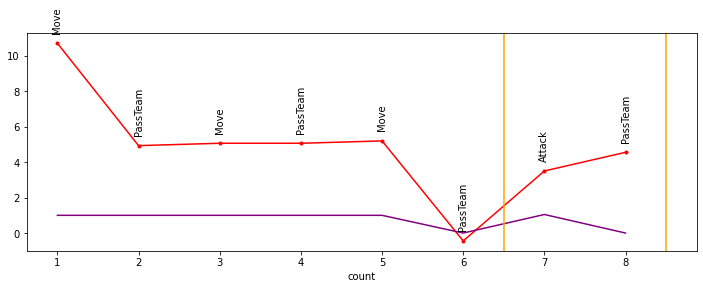

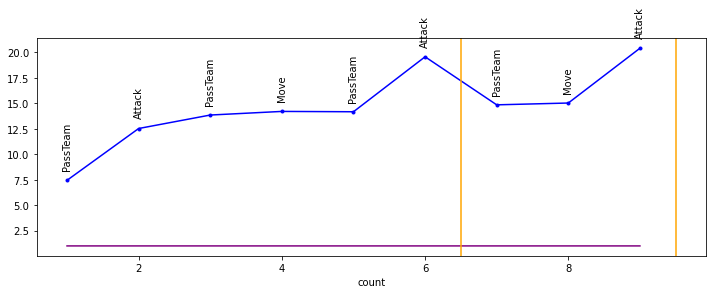

In [13]:
playAndAnalyze(seed, red_models[0], blue_models[0]);

# Tourney!

In [14]:
random.seed(seed)

seed:    255346
red  -> RegressionAgent
blue -> RegressionAgent
winner:  red


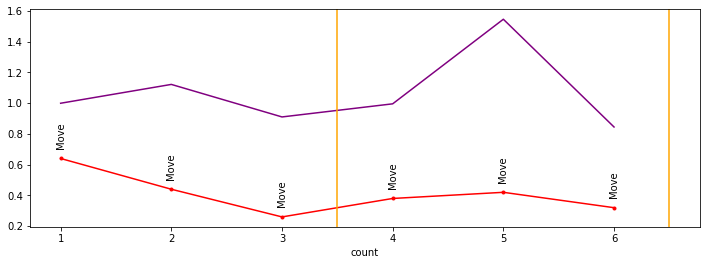

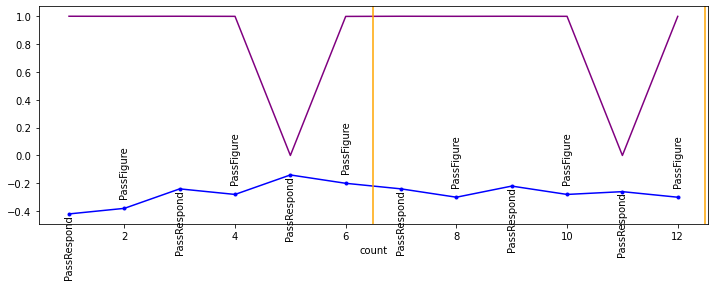

In [15]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    169803
red  -> ClassifierAgent
blue -> ClassifierAgent
winner:  blue


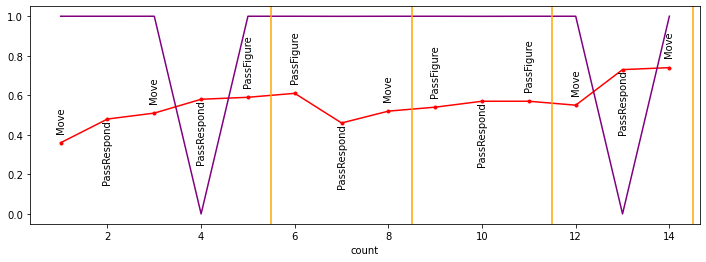

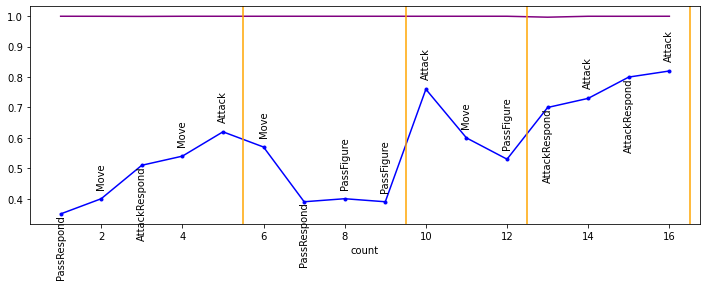

In [16]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    873043
red  -> RegressionAgent
blue -> ClassifierAgent
winner:  blue


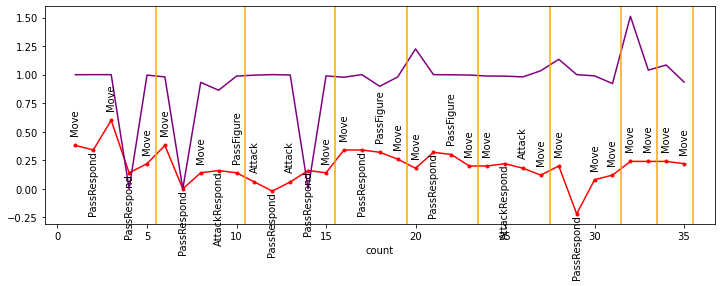

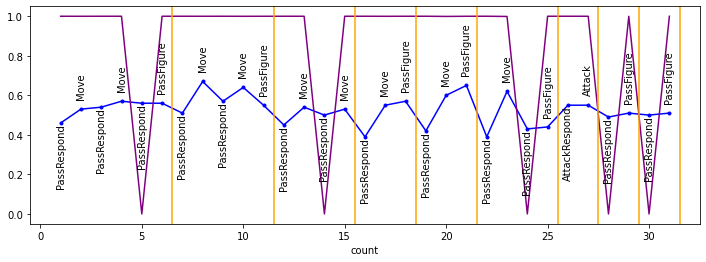

In [17]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    971356
red  -> RegressionAgent
blue -> RegressionAgent
winner:  blue


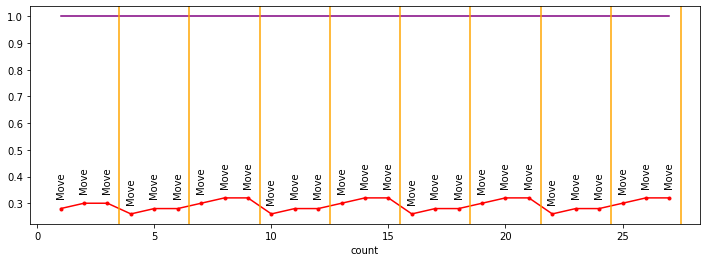

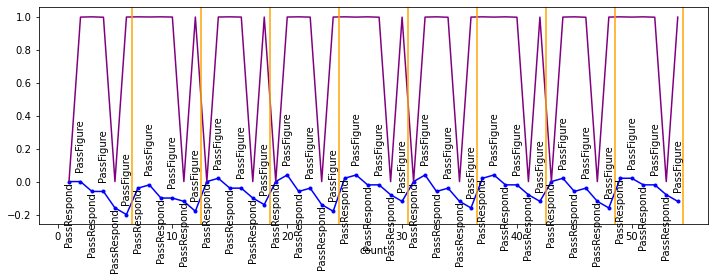

In [18]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    486141
red  -> RegressionAgent
blue -> RegressionAgent
winner:  blue


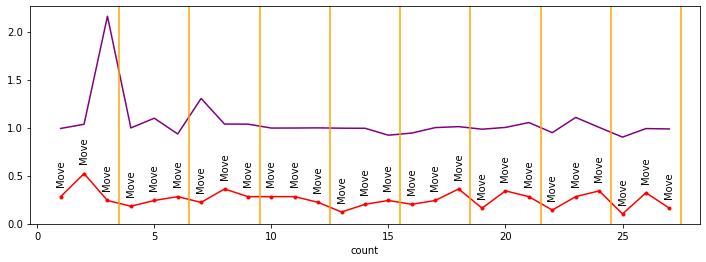

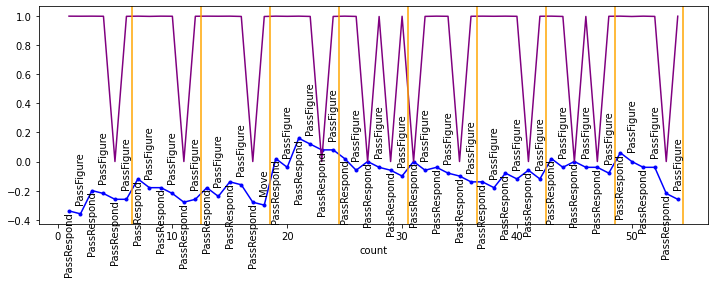

In [19]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    659473
red  -> ClassifierAgent
blue -> RegressionAgent
winner:  blue


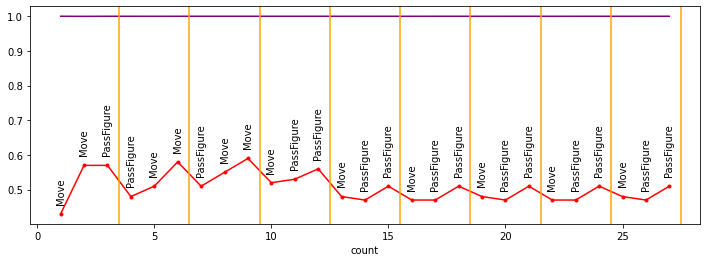

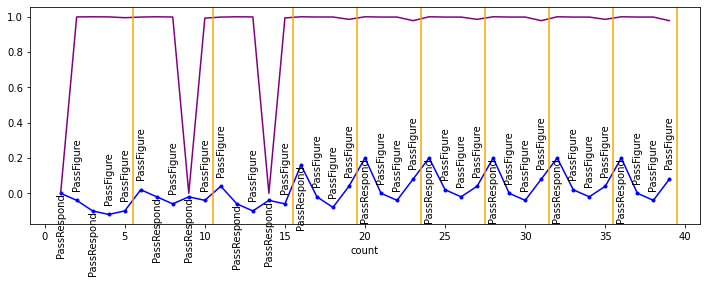

In [20]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    692733
red  -> ClassifierAgent
blue -> RegressionAgent
winner:  blue


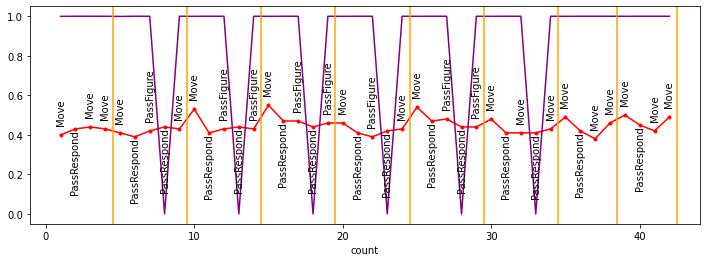

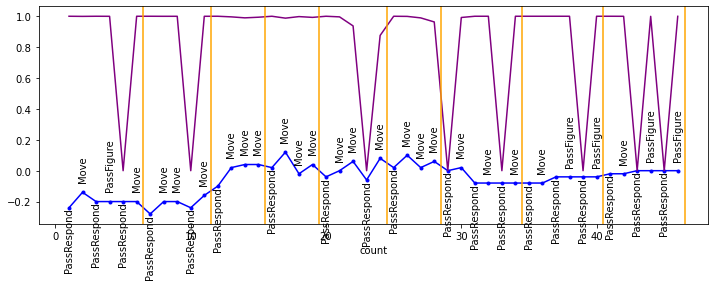

In [21]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    291185
red  -> RegressionAgent
blue -> GreedyAgent
winner:  blue


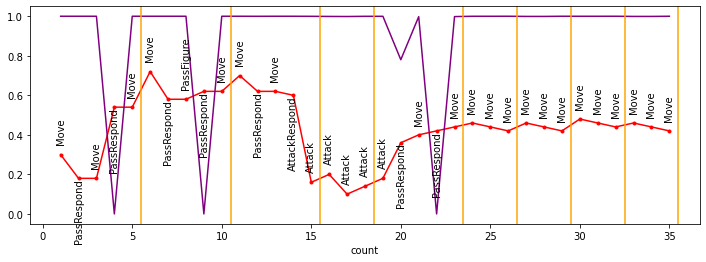

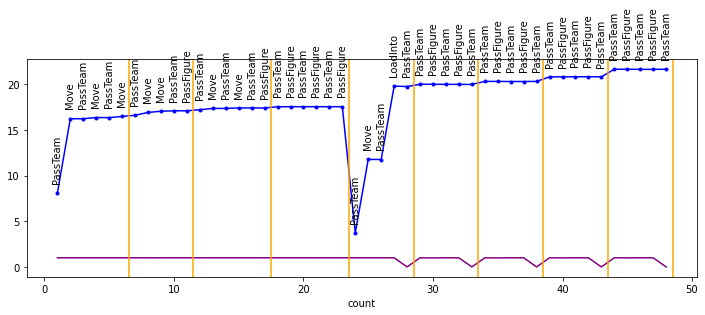

In [22]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    893987
red  -> GreedyAgent
blue -> GreedyAgent
winner:  red


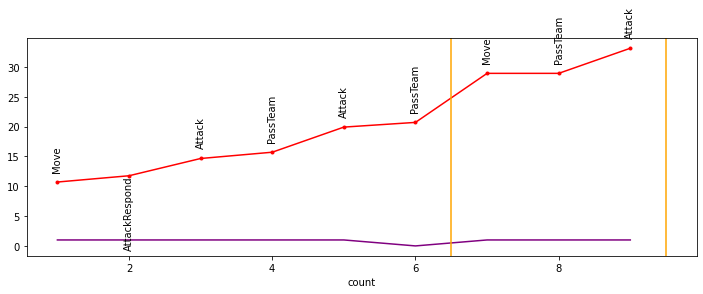

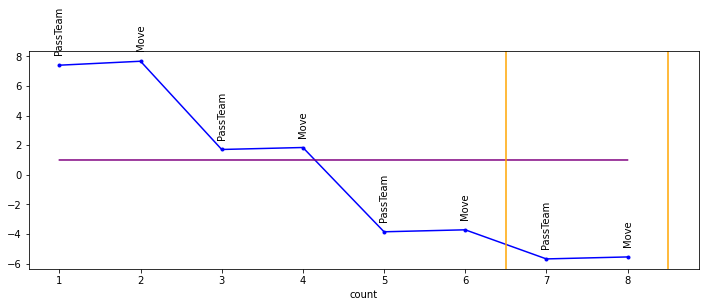

In [23]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);